In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
import malaya

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [5]:
with open('emotion-dictionary.json') as fopen:
    d = json.load(fopen)
dictionary = d['dictionary']
rev_dictionary = d['reverse_dictionary']

In [6]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def Attention(inputs, num_units, num_heads = 8, activation = None):
    inputs = tf.layers.dropout(inputs, 0.3, training=True)
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, size_layer, embed_size, dict_size, dimension_output, learning_rate = 1e-3):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embed_size], -1, 1))
        x = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        x += position_encoding(x)
        x = tf.layers.dropout(x, 0.3, training=True) 
        
        x, self.alignments = Attention(x, size_layer)
        self.logits_seq = tf.layers.dense(x, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:,-1]
        self.logits = tf.identity(self.logits, name = 'logits')

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [7]:
size_layer = 256
dimension_output = 6
learning_rate = 1e-4
batch_size = 32
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    size_layer,
    len(dictionary),
    dimension_output,
    learning_rate,
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [8]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)

In [9]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'dense_1/kernel',
 'dense_1/bias',
 'logits_seq',
 'logits',
 'alphas']

In [10]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [11]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.812, cost=0.499]

epoch: 0, pass acc: 0.000000, current acc: 0.727349
time taken: 731.6978554725647
epoch: 0, training loss: 0.905357, training acc: 0.647174, valid loss: 0.655899, valid acc: 0.727349



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.89it/s, accuracy=0.781, cost=0.542]

epoch: 1, pass acc: 0.727349, current acc: 0.766111
time taken: 729.8395171165466
epoch: 1, training loss: 0.598457, training acc: 0.750146, valid loss: 0.555720, valid acc: 0.766111



train minibatch loop:   0%|          | 2/10513 [00:00<11:44, 14.93it/s, accuracy=0.875, cost=0.3]

epoch: 2, pass acc: 0.766111, current acc: 0.786443
time taken: 729.3791365623474
epoch: 2, training loss: 0.527514, training acc: 0.780100, valid loss: 0.507350, valid acc: 0.786443



train minibatch loop:   0%|          | 2/10513 [00:00<11:43, 14.95it/s, accuracy=0.812, cost=0.466]

epoch: 3, pass acc: 0.786443, current acc: 0.801199
time taken: 729.3505957126617
epoch: 3, training loss: 0.486415, training acc: 0.797101, valid loss: 0.476010, valid acc: 0.801199



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.781, cost=0.456]

epoch: 4, pass acc: 0.801199, current acc: 0.809795
time taken: 729.101904630661
epoch: 4, training loss: 0.459273, training acc: 0.808106, valid loss: 0.453751, valid acc: 0.809795



train minibatch loop:   0%|          | 2/10513 [00:00<11:42, 14.96it/s, accuracy=0.844, cost=0.368]

epoch: 5, pass acc: 0.809795, current acc: 0.813564
time taken: 728.9868063926697
epoch: 5, training loss: 0.439415, training acc: 0.815298, valid loss: 0.440682, valid acc: 0.813564



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.812, cost=0.414]

epoch: 6, pass acc: 0.813564, current acc: 0.821162
time taken: 729.0955126285553
epoch: 6, training loss: 0.426599, training acc: 0.819502, valid loss: 0.423938, valid acc: 0.821162



train minibatch loop:   0%|          | 2/10513 [00:00<11:47, 14.87it/s, accuracy=0.812, cost=0.423]

epoch: 7, pass acc: 0.821162, current acc: 0.823112
time taken: 729.2301309108734
epoch: 7, training loss: 0.414481, training acc: 0.823978, valid loss: 0.410924, valid acc: 0.823112



train minibatch loop:   0%|          | 2/10513 [00:00<11:46, 14.88it/s, accuracy=0.844, cost=0.422]

epoch: 8, pass acc: 0.823112, current acc: 0.825835
time taken: 729.1006045341492
epoch: 8, training loss: 0.403511, training acc: 0.827747, valid loss: 0.406086, valid acc: 0.825835



train minibatch loop:   0%|          | 2/10513 [00:00<11:46, 14.88it/s, accuracy=0.75, cost=0.491]

epoch: 9, pass acc: 0.825835, current acc: 0.826441
time taken: 729.0860552787781
epoch: 9, training loss: 0.394586, training acc: 0.830611, valid loss: 0.398988, valid acc: 0.826441



train minibatch loop:   0%|          | 2/10513 [00:00<11:48, 14.84it/s, accuracy=0.812, cost=0.437]

epoch: 10, pass acc: 0.826441, current acc: 0.829271
time taken: 729.1331174373627
epoch: 10, training loss: 0.387683, training acc: 0.831868, valid loss: 0.390499, valid acc: 0.829271



train minibatch loop:   0%|          | 2/10513 [00:00<11:44, 14.92it/s, accuracy=0.75, cost=0.45]

epoch: 11, pass acc: 0.829271, current acc: 0.830056
time taken: 729.1033494472504
epoch: 11, training loss: 0.380850, training acc: 0.834213, valid loss: 0.387611, valid acc: 0.830056



train minibatch loop:   0%|          | 2/10513 [00:00<11:47, 14.86it/s, accuracy=0.812, cost=0.368]

epoch: 12, pass acc: 0.830056, current acc: 0.831387
time taken: 729.0544452667236
epoch: 12, training loss: 0.375699, training acc: 0.835616, valid loss: 0.382575, valid acc: 0.831387



train minibatch loop:   0%|          | 2/10513 [00:00<11:47, 14.86it/s, accuracy=0.812, cost=0.347]

time taken: 729.0663626194
epoch: 13, training loss: 0.370870, training acc: 0.837109, valid loss: 0.381337, valid acc: 0.830210



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.91it/s, accuracy=0.844, cost=0.321]

epoch: 14, pass acc: 0.831387, current acc: 0.832184
time taken: 729.068371295929
epoch: 14, training loss: 0.366446, training acc: 0.838544, valid loss: 0.375796, valid acc: 0.832184



train minibatch loop:   0%|          | 2/10513 [00:00<11:46, 14.87it/s, accuracy=0.812, cost=0.376]

epoch: 15, pass acc: 0.832184, current acc: 0.833563
time taken: 729.2165334224701
epoch: 15, training loss: 0.363456, training acc: 0.838815, valid loss: 0.374733, valid acc: 0.833563



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.844, cost=0.331]

time taken: 729.1978690624237
epoch: 16, training loss: 0.359132, training acc: 0.840049, valid loss: 0.373113, valid acc: 0.832707



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.91it/s, accuracy=0.75, cost=0.428]

time taken: 729.1302597522736
epoch: 17, training loss: 0.355423, training acc: 0.841169, valid loss: 0.368639, valid acc: 0.833278



train minibatch loop:   0%|          | 2/10513 [00:00<11:43, 14.94it/s, accuracy=0.812, cost=0.341]

epoch: 18, pass acc: 0.833563, current acc: 0.833896
time taken: 729.2176496982574
epoch: 18, training loss: 0.352978, training acc: 0.841359, valid loss: 0.368497, valid acc: 0.833896



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.844, cost=0.273]

epoch: 19, pass acc: 0.833896, current acc: 0.835561
time taken: 729.1488280296326
epoch: 19, training loss: 0.349954, training acc: 0.842385, valid loss: 0.362723, valid acc: 0.835561



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.91it/s, accuracy=0.875, cost=0.272]

time taken: 729.1898145675659
epoch: 20, training loss: 0.347365, training acc: 0.843428, valid loss: 0.362455, valid acc: 0.833979



train minibatch loop:   0%|          | 2/10513 [00:00<11:45, 14.90it/s, accuracy=0.812, cost=0.326]

time taken: 729.206015586853
epoch: 21, training loss: 0.345617, training acc: 0.843520, valid loss: 0.359533, valid acc: 0.834086



test minibatch loop: 100%|██████████| 2629/2629 [00:22<00:00, 117.09it/s, accuracy=0.875, cost=0.105] 

time taken: 729.2785265445709
epoch: 22, training loss: 0.342237, training acc: 0.844296, valid loss: 0.359588, valid acc: 0.834181

break epoch:23



In [12]:
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [13]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.67638516, 0.0042767 , 0.00291029, 0.02935026, 0.23952654,
        0.04755105]], dtype=float32)

In [14]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run([tf.nn.softmax(model.logits_seq), model.attention], feed_dict={model.X:new_vector})

[array([[[6.31391769e-03, 4.56804894e-02, 2.21061986e-03, 4.09578323e-01,
          2.85104007e-01, 2.51112700e-01],
         [1.02130912e-01, 2.20702365e-02, 2.67399265e-03, 9.51586440e-02,
          6.47424817e-01, 1.30541399e-01],
         [5.37537411e-02, 1.50353706e-03, 4.99343267e-03, 4.11306053e-01,
          5.04247367e-01, 2.41958518e-02],
         [9.89125967e-01, 1.14880524e-04, 1.28736847e-05, 1.05202815e-03,
          8.38419423e-03, 1.31011382e-03],
         [2.22332273e-02, 9.59710800e-04, 9.57809796e-04, 3.40199992e-02,
          8.58260930e-01, 8.35683569e-02],
         [9.93680239e-01, 2.64354894e-04, 1.86971210e-05, 2.17315566e-04,
          4.84278053e-03, 9.76616284e-04],
         [5.98695040e-01, 3.87248467e-04, 1.83452750e-04, 4.41529136e-03,
          3.80682558e-01, 1.56364534e-02],
         [6.08286619e-01, 1.20844168e-03, 1.88731239e-04, 1.08873714e-02,
          3.75834495e-01, 3.59435077e-03]]], dtype=float32),
 array([0.29801446, 0.07011506, 0.14716882, 0.

In [15]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 2629/2629 [00:19<00:00, 137.83it/s]


In [16]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
    )
)

             precision    recall  f1-score   support

      anger       0.90      0.90      0.90     14869
       fear       0.83      0.85      0.84      7682
        joy       0.87      0.90      0.89     16658
       love       0.92      0.90      0.91     15767
    sadness       0.77      0.74      0.76     19866
   surprise       0.64      0.67      0.66      9262

avg / total       0.83      0.83      0.83     84104



In [17]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [18]:
freeze_graph('only-attention', strings)

INFO:tensorflow:Restoring parameters from only-attention/model.ckpt
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.
248 ops in the final graph.


In [19]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [20]:
g = load_graph('only-attention/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [23]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

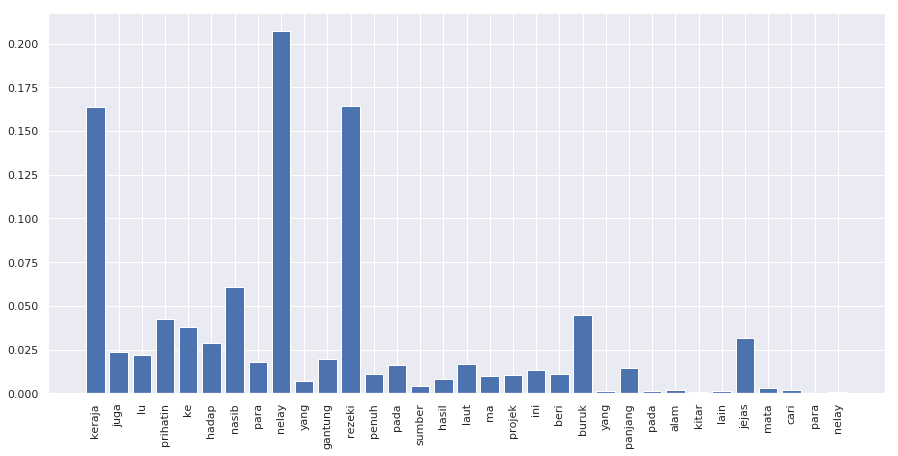

In [25]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()

In [26]:
result[2]

array([[[3.57826166e-02, 3.96472897e-04, 1.59756336e-02, 3.90590310e-01,
         5.30455232e-01, 2.67997421e-02],
        [1.67966858e-02, 3.78293393e-04, 4.24483232e-03, 6.44199774e-02,
         9.06710088e-01, 7.45004369e-03],
        [5.94010614e-02, 5.88332885e-04, 4.31317836e-02, 6.44679442e-02,
         7.84338474e-01, 4.80723865e-02],
        [1.34910932e-02, 3.76882555e-04, 6.32534968e-03, 1.09262384e-01,
         8.35589051e-01, 3.49552408e-02],
        [3.68006295e-03, 7.40904579e-05, 6.51545066e-04, 1.52156912e-02,
         9.74577188e-01, 5.80132660e-03],
        [2.91984179e-03, 2.24231728e-04, 6.42385974e-04, 2.08916496e-02,
         9.58328426e-01, 1.69934761e-02],
        [6.99942047e-03, 1.10864428e-04, 8.09886842e-04, 3.44670154e-02,
         9.38600004e-01, 1.90127864e-02],
        [3.88900656e-03, 3.65889980e-04, 7.75634311e-04, 8.25500116e-02,
         8.83286774e-01, 2.91326102e-02],
        [1.56838611e-01, 3.44735174e-03, 7.71176245e-04, 1.49044162e-02,
       